In [90]:
from astropy.io import fits
import  matplotlib.pyplot as plt
import numpy as np
from astropy.cosmology import Planck15 as cosmo
from scipy.interpolate import interp1d



In [91]:
d='/home/s/sievers/sdicker/ACTnCOWs/'
act=fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/MADCOWSUnion_M500.fits')
mc=fits.open(d+'MADCOWSUnion.fits')
ACTnCOWS=fits.open('/home/r/rbond/jorlo/dev/madcowsclusters/ACTCOWS_matches_V04.fits')

print(cosmo.efunc(0))

1.0


In [92]:
def f_rel(M500, z):
    #Compute the relativistic tSZ correction from Hasslefield 2013
    t = -0.00848*(M500*cosmo.efunc(z))**(-0.585)
    return  1 + 3.79*t - 28.2*t**2


In [93]:
hdu = fits.open('/project/r/rbond/jorlo/S18d_202006/selFn/QFit.fits')
hdr = hdu[1].header 
temp = []
for i, key in enumerate(hdr.keys()):
    #print(hdr[key], i)
    if i>10 and ((i % 2) == 0):
        temp.append(hdu[1].data[str(hdr[key])])
Q_interp = interp1d(hdu[1].data['theta500Arcmin'], np.mean(temp, axis = 0))

def Q(interp, theta = 2.4):    
    return interp(theta)
    


In [94]:
def MtoY0(M500, z = 0.7):
    #Convert M500 to y0, see Hilton 2020, eq. (1) and discussion. M must be in units M_solar *10**14
    if type(M500) == int:
        A0, Mpivot = 4.95e-5, 3
        y0 = A0*(cosmo.efunc(z))**2*(M500/Mpivot)**1.08*Q(Q_interp, 2.4)*f_rel(M500, z)
        return y0
    else:
        temp = np.zeros(len(M500))
        A0, Mpivot = 4.95e-5, 3
        for i, M in enumerate(M500):
            temp[i] = A0*(cosmo.efunc(z))**2*(M/Mpivot)**1.08*Q(Q_interp, 2.4)*f_rel(M, z)
        return temp

In [95]:
print(MtoY0([3,4]))

[0.00010799 0.00014767]


In [96]:
richness = np.zeros(act[1].data[:]['name'].shape[0])
richness_e = np.zeros(act[1].data[:]['name'].shape[0])
mc_z=np.zeros(act[1].data[:]['name'].shape[0])
mc_m500=np.zeros(act[1].data[:]['name'].shape[0])
for ni,name in enumerate(act[1].data[:]['name']):
    ind=np.where(mc[1].data[:]['name'] == name)[0]
    if ind.shape[0] == 0:
        print('ERROR no match found for ',name) # should never get here...
    elif ind.shape[0] > 1:
        print('ERROR more than 1 match found for ',name)# should never get here
    else :
        richness[ni]=mc[1].data[ind[0]]['Rich']
        richness_e[ni]=mc[1].data[ind[0]]['e_Rich']
        mc_z[ni]=mc[1].data[ind[0]]['Photz']
        mc_m500[ni]=mc[1].data[ind[0]]['M500']
print('Done cutting data')

gi_rich=np.where(richness < 5e4)[0]
gi_act_m500=np.where(np.isnan(act[1].data[:]['M500']) == 0)[0]#will have z and positive y0
gi_act_z=np.where(np.isnan(act[1].data[:]['redshift']) == 0)[0]

Done cutting data


In [97]:
gi_rich=np.where(richness < 5e4)[0]
gi_act_m500=np.where(np.isnan(act[1].data[:]['M500']) == 0)[0]#will have z and positive y0
gi_act_z=np.where(np.isnan(act[1].data[:]['redshift']) == 0)[0]

mass_from_richness=np.zeros(richness.shape)
alpha=1.65 #+1.45-0.96 CARMA values
beta=-2.16 #+1.57-2.38
mass_from_richness[gi_rich]= 10.**(alpha*np.log10(richness[gi_rich])+beta)
a2=0.44 #+0.77-0.70
b2=-0.35 #+1.19-1.31
mass_from_richness2=np.zeros(richness.shape)
mass_from_richness2[gi_rich]= 10.**(a2*np.log10(richness[gi_rich])+b2)

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log10
  
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == '':


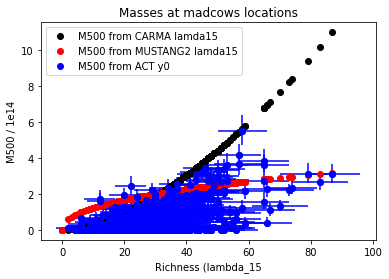

In [8]:
f=plt.figure()
plt.plot(richness[gi_rich],mass_from_richness[gi_rich],'ok',label='M500 from CARMA lamda15')
plt.plot(richness[gi_rich],mass_from_richness2[gi_rich],'or',label='M500 from MUSTANG2 lamda15')
gi=np.where((richness != 0) & (np.isnan(act[1].data[:]['M500']) == 0) & (richness < 5e4))[0]
plt.plot(richness[gi],act[1].data[gi]['M500'],'ob',label='M500 from ACT y0')
plt.errorbar(richness[gi],act[1].data[gi]['M500'],xerr=richness_e[gi],yerr=(act[1].data[gi]['M500_errMinus'],act[1].data[gi]['M500_errPlus']),fmt='ob')
plt.xlabel('Richness (lambda_15')
plt.ylabel('M500 / 1e14')
plt.title('Masses at madcows locations')
plt.legend()
plt.savefig('./plots/ACT_m500_from_y0_forced.pdf')

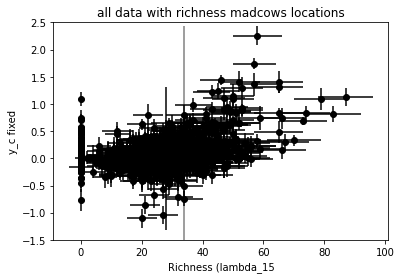

In [9]:
f=plt.figure()
gi_rich2=np.where((richness < 5e4) & (act[1].data[:]['fixed_err_y_c'] > 0.75))[0]
plt.errorbar(richness[gi_rich2],act[1].data[gi_rich2]['fixed_y_c'],xerr=richness_e[gi_rich2],yerr=act[1].data[gi_rich2]['fixed_err_y_c'],fmt='o',color='grey')
gi_rich1=np.where((richness < 5e4) & (act[1].data[:]['fixed_err_y_c'] <= 0.75))[0]
#plt.plot(richness[gi_rich],act[1].data[gi_rich]['fixed_y_c'],'ok')
plt.errorbar(richness[gi_rich1],act[1].data[gi_rich1]['fixed_y_c'],xerr=richness_e[gi_rich1],yerr=np.abs(act[1].data[gi_rich1]['fixed_err_y_c']),fmt='ok')
plt.xlabel('Richness (lambda_15')
plt.ylabel('y_c fixed')
plt.title('all data with richness madcows locations')
plt.ylim((-1.5,2.5)) 
plt.savefig('./plots/ACT_y0_forced.pdf')

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less_equal
  


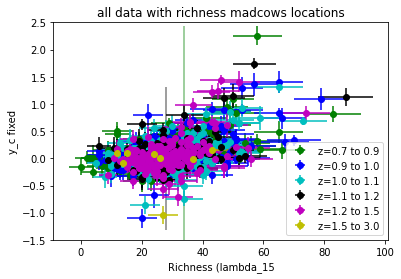

In [10]:
f=plt.figure()
rl=[0.1,0.7,0.9,1.0,1.1,1.2,1.5,3.]
colours=['r','g','b','c','k','m','y','p']
for rr in range(len(rl)-1) : #first plot the points with large y_c errors
    gi_rich2=np.where((richness < 5e4) & (np.abs(act[1].data[:]['fixed_err_y_c']) > 0.75) & (mc_z > rl[rr]) & (mc_z <= rl[rr+1])  )[0]
    if gi_rich2.shape[0] > 0 : plt.errorbar(richness[gi_rich2],act[1].data[gi_rich2]['fixed_y_c'],xerr=richness_e[gi_rich2],yerr=act[1].data[gi_rich2]['fixed_err_y_c'],fmt='o',color=colours[rr],alpha=0.5)
for rr in range(len(rl)-1) :
    gi_rich1=np.where((richness < 5e4) & (np.abs(act[1].data[:]['fixed_err_y_c']) <= 0.75) & (mc_z > rl[rr]) & (mc_z <= rl[rr+1]))[0]
    #plt.plot(richness[gi_rich],act[1].data[gi_rich]['fixed_y_c'],'ok')
    if gi_rich1.shape[0] > 0 : plt.errorbar(richness[gi_rich1],act[1].data[gi_rich1]['fixed_y_c'],xerr=richness_e[gi_rich1],yerr=np.abs(act[1].data[gi_rich1]['fixed_err_y_c']),fmt='o',color=colours[rr],label='z={} to {}'.format(rl[rr],rl[rr+1]))
plt.xlabel('Richness (lambda_15')
plt.ylabel('y_c fixed')
plt.title('all data with richness madcows locations')
plt.ylim((-1.5,2.5)) 
plt.legend()
plt.savefig('./plots/ACT_y0_forced_by_z.pdf')

/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log10
  after removing the cwd from sys.path.
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log10
  import sys
/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/home/r/rbond/jorl

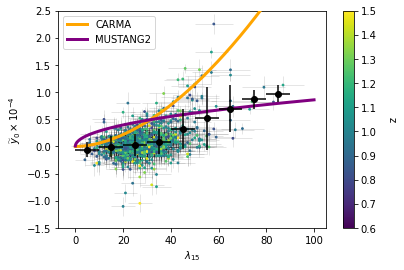

In [104]:
x0 = np.linspace(0, 100, 10000)
alpha=1.65 #+1.45-0.96 CARMA values
beta=-2.16 #+1.57-2.38
mass_from_richness = lambda x: 10.**(alpha*np.log10(x)+beta)
a2=0.44 #+0.77-0.70
b2=-0.35 #+1.19-1.31
mass_from_richness2 = lambda x: 10.**(a2*np.log10(x)+b2)


f=plt.figure()

#print(mass_from_richness(x0))

plt.ylim(-1.5, 2.5)
rl=[0.1,0.7,0.9,1.0,1.1,1.2,1.5,3.]
yz=np.zeros(len(rl)-1)
yzw=np.zeros(len(rl)-1)
n=np.zeros(len(rl)-1)
colours=['r','g','b','c','k','m','y','p']
#for rr in range(len(rl)-1) : #first plot the points with large y_c errors
#    gi_rich2=np.where((richness < 5e4) & (act[1].data[:]['fixed_err_y_c'] > 0.75) & (mc_z > rl[rr]) & (mc_z <= rl[rr+1])  )[0]
#    if gi_rich2.shape[0] > 0 : plt.errorbar(richness[gi_rich2],act[1].data[gi_rich2]['fixed_y_c'],xerr=richness_e[gi_rich2],yerr=act[1].data[gi_rich2]['fixed_err_y_c'],fmt='o',color=colours[rr],alpha=0.5)
#print(mc_z)

"""
for rr in range(len(rl)-1) :
    gi_rich1=np.where((richness < 5e4) & (np.abs(act[1].data[:]['fixed_err_y_c']) <= 0.75) & (mc_z > rl[rr]) & (mc_z <= rl[rr+1]))[0]
    #plt.plot(richness[gi_rich],act[1].data[gi_rich]['fixed_y_c'],'ok')
    if gi_rich1.shape[0] > 0 : 
        plt.scatter(richness[gi_rich1], act[1].data[gi_rich1]['fixed_y_c'], c = mc_z[gi_rich1], zorder = 2, vmin = 0, vmax = 2)
        plt.errorbar(richness[gi_rich1],act[1].data[gi_rich1]['fixed_y_c'],xerr=richness_e[gi_rich1],yerr=np.abs(act[1].data[gi_rich1]['fixed_err_y_c']),fmt='o', alpha = 0.5, color = 'black', zorder = 1)#,color=colours[rr])#,label='z={} to {}'.format(rl[rr],rl[rr+1]))
    yzw[rr]=1.0/np.sqrt(np.sum(1.0/act[1].data[gi_rich1]['fixed_err_y_c']**2))
    yz[rr]=np.sum(act[1].data[gi_rich1]['fixed_y_c']/act[1].data[gi_rich1]['fixed_err_y_c']**2)/np.sum(1.0/act[1].data[gi_rich1]['fixed_err_y_c']**2)
    n[rr]=gi_rich1.shape[0]
"""
gi_rich1=np.where((richness > 0) & (richness < 5e4) & (np.abs(act[1].data[:]['fixed_err_y_c']) <= 0.75))[0]
#plt.scatter(richness[gi_rich1], act[1].data[gi_rich1]['fixed_y_c'], zorder = 2, c = 'green', s = 1)
plt.scatter(richness[gi_rich1], act[1].data[gi_rich1]['fixed_y_c'], zorder = 2, s = 3, c = mc_z[gi_rich1], vmin = 0.6, vmax = 1.5)
plt.errorbar(richness[gi_rich1],act[1].data[gi_rich1]['fixed_y_c'],xerr=richness_e[gi_rich1],yerr=np.abs(act[1].data[gi_rich1]['fixed_err_y_c']),
             fmt='o', alpha = 0.2, ecolor = 'black', zorder = 1, ms = 1, elinewidth = 0.5)#,color=colours[rr])#,label='z={} to {}'.format(rl[rr],rl[rr+1]))    
    
r_bins = np.arange(5,95, 10)
r_binned = np.zeros(len(r_bins))
r_binned_err = np.zeros(len(r_bins))
for i, rmean in enumerate(r_bins):
    flags = np.where((richness > (rmean-5)) & (richness <= (rmean+5)))[0]
    r_binned[i] = np.mean(act[1].data[flags]['fixed_y_c'])
    r_binned_err[i] = np.std(act[1].data[flags]['fixed_y_c'])
    
plt.errorbar(r_bins, r_binned, xerr = 5, yerr = r_binned_err, zorder = 11, linestyle = 'none', fmt='o', alpha = 1, color = 'black')
    
    
cbar = plt.colorbar()
cbar.set_label('z', rotation=270, labelpad = 20)

plt.plot(x0,MtoY0(mass_from_richness(x0), z = 0.4)*1e4, label='CARMA', color = 'orange', zorder = 10, linewidth = 3)
plt.plot(x0,MtoY0(mass_from_richness2(x0), z = 0.4)*1e4, label='MUSTANG2', color = 'purple', zorder = 10, linewidth = 3)
plt.ylabel(r'$\widetilde{y}_0\times 10^{-4}$')
plt.xlabel(r'$\lambda_{15}$')
plt.legend()
plt.savefig('./plots/ACT_y0_forced_by_z_no_large_err.pdf')
#plt.savefig('./plots/ACT_y0_forced_for_site_visit.png', dpi = 300)

No handles with labels found to put in legend.


Richness bin 1 to 10 has y0=-0.024938504921118296+-0.02800677594976414 with 22.0 clusters
Richness bin 10 to 20 has y0=0.001494599646724818+-0.010266955777478364 with 160.0 clusters
Richness bin 20 to 30 has y0=0.0012592088765661777+-0.0014139412873904805 with 370.0 clusters
Richness bin 30 to 40 has y0=0.08251518017762775+-0.008073440671523602 with 269.0 clusters
Richness bin 40 to 50 has y0=0.29135045462879383+-0.012978827330545275 with 96.0 clusters
Richness bin 50 to 60 has y0=0.49336731519943866+-0.02352447665119208 with 36.0 clusters
Richness bin 60 to 100 has y0=0.7420103808208087+-0.03551024130094635 with 13.0 clusters


/home/r/rbond/jorlo/actmadcows/lib/python3.6/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10


TypeError: 'function' object does not support item assignment

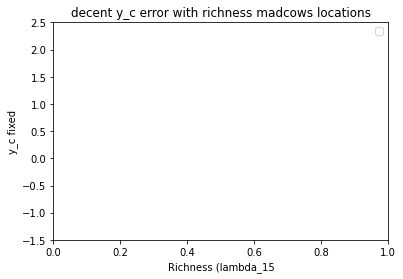

In [12]:
plt.xlabel('Richness (lambda_15')
plt.ylabel('y_c fixed')
plt.title('decent y_c error with richness madcows locations')
plt.ylim((-1.5,2.5)) 
plt.legend()

#r_bins=[1,10,15,20,25,30,35,40,45,50,60,100]
r_bins=[1,10,20,30,40,50,60,100]
y_ave=np.zeros(len(r_bins)-1)
ye_ave=np.zeros(len(r_bins)-1)
n_ave=np.zeros(len(r_bins)-1)
for rr in range(len(r_bins)-1) :
    gi=np.where((richness < r_bins[rr+1]) & (richness >= r_bins[rr]))[0]
    ye_ave[rr]=1.0/np.sqrt(np.sum(1.0/act[1].data[gi]['fixed_err_y_c']**2))
    y_ave[rr]=np.sum(act[1].data[gi]['fixed_y_c']/act[1].data[gi]['fixed_err_y_c']**2)/np.sum(1.0/act[1].data[gi]['fixed_err_y_c']**2)
    n_ave[rr]=gi.shape[0]
    print('Richness bin '+repr(r_bins[rr])+' to '+repr(r_bins[rr+1])+' has y0='+repr(y_ave[rr])+'+-'+repr(ye_ave[rr])+' with '+repr(n_ave[rr])+' clusters')

alpha=1.65 #+1.45-0.96 CARMA values
beta=-2.16 #+1.57-2.38
mass_from_richness[gi_rich]= 10.**(alpha*np.log10(richness[gi_rich])+beta)
a2=0.44 #+0.77-0.70
b2=-0.35 #+1.19-1.31
r_bins=[1,10,15,20,25,30,35,40,45,50,60,70]
for rr in range(1,len(r_bins)):
    mc=10.**(alpha*np.log10(r_bins[rr])+beta)
    mm=10.**(a2*np.log10(r_bins[rr])+b2)
    print('Richness '+repr(r_bins[rr])+' has prediced mass of '+repr(mc)+'(carma) and '+repr(mm)+'(MUSTANG2)')

In [77]:
flags = np.where((act[1].data[gi_rich1]['fixed_y_c']<-0.5))[0]

In [88]:
name_flags = np.where((act[1].data[gi_rich1]['name'] == 'MOO J1404+6550'))[0]

In [89]:
print((act[1].data[gi_rich1]['fixed_y_c'][name_flags]))

[]


In [79]:
act[1].data[gi_rich1]['name'][flags]

chararray(['MOO J0043-2338', 'MOO J0208-2951', 'MOO J0306+0857',
           'MOO J0354-2522', 'MOO J0936+0336', 'MOO J2052-1408',
           'MOO J2247+0507', 'MOO J2347-2734'], dtype='<U14')